# ML Pipeline Workflow
# 

### Planning
<u>Model Selection:</u>  
We will use 2 different classifiers for comparison.  We will use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [XGBoost Classifier](https://xgboost.readthedocs.io/en/stable/).  We will use these models to classify messages to the appropriate agency and test for accuracy.  

<u>Evaluation Metric:</u><br><br>
$Precision = \frac{TP}{TP + FP}$<br><br>
We will use Precision.  Precision is the ratio of correctly predicted positive observations to the total predicted positives.  Precision is a good measure to determine, when the costs of False Positive is high.  In this case, a False positive will result in leaving someone stranded, who needs help.
    

### Pipeline Workflow


### Model Evaluation



### 1. Import Required Libraries

In [1]:
# import libraries
import re # for regular expressions
import numpy as np # numeric python, vector operations
import pandas as pd # data manipulation
from nltk.corpus import stopwords # natural language tool kit: stopwords
from nltk.tokenize import word_tokenize # natural language tool kit: word_tokenize
from nltk.stem import WordNetLemmatizer # natural language tool kit: lemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # for text processing
from sklearn.model_selection import train_test_split # for splitting data into training and testing
from sklearn.multioutput import MultiOutputClassifier   # for multi-output classification
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.pipeline import Pipeline   # for creating a pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score # for model evaluation

import warnings 
warnings.filterwarnings('ignore')

###  2. Load the dataset
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../data/disaster_response.db')
df = pd.read_sql_table('features', engine) 
X = df['message']
y = df.iloc[:,4:]

### 3. Create a Customer Text Transformer

In [3]:
# create custom text transformer

def tokenize(text):
    """
    This function takes a text and returns a list of cleaned and tokenized words.
    Designed to be used in a pipeline, with the CountVectorizer and TfidfTransformer objects

    Args:
    text: str: a string of text to be tokenized

    Returns:
    lemmed: list: a list of cleaned and tokenized words
    """
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # Lemmatization
    words = [WordNetLemmatizer().lemmatize(w) for w in words]

    # Stemming (not used, does not improve performance)
    # stemmed = [PorterStemmer().stem(w) for w in lemmed]
    
    return words
    

### Test Tokenization Function

In [4]:
# test out function
for message in X.sample(5):
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

and if I had another problem in my eyes, me I have a problem in my eyes. how do have been able to help me? 
['another', 'problem', 'eye', 'problem', 'eye', 'able', 'help'] 

What kind of information can we find for this season? 
['kind', 'information', 'find', 'season'] 

About 1,000 electricity pylons and poles have collapsed around Chenzhou under the weight of ice and snow, effectively destroying the local power grid.
['1', '000', 'electricity', 'pylon', 'pole', 'collapsed', 'around', 'chenzhou', 'weight', 'ice', 'snow', 'effectively', 'destroying', 'local', 'power', 'grid'] 

.  /    khairo Disctt. Jacobabad.
['khairo', 'disctt', 'jacobabad'] 

Wish there was a frankenstorm emoji
['wish', 'frankenstorm', 'emoji'] 



### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Pipeline will have 3 steps
# 1. CountVectorizer - Convert a collection of text documents to a matrix of token counts
# 2. TfidfTransformer - Transform a count matrix to a normalized tf or tf-idf representation
# 3. MultiOutputClassifier - This is a simple meta-estimator for fitting one classifier per target.
def build_pipeline():
    """
    This function builds a pipeline for text processing and multi-output classification

    Returns:
    pipeline: Pipeline: a pipeline object that processes text and classifies it
    """
    pipeline = Pipeline([ 
        ('vect', CountVectorizer(tokenizer=tokenize,
                                min_df=5,
                                max_df=0.75)), # here is where you use the custom text transformer
        ('tfidf', TfidfTransformer()), # use the TfidfTransformer
        ('clf', MultiOutputClassifier(RandomForestClassifier(verbose=1))) # use the RandomForestClassifier  
    ])
    return pipeline

pipeline = build_pipeline()

### Train pipeline with the Benchmark model (we will look to improve through more iterations)
- Split data into train and test sets
- Train pipeline

### Observe the hyperparameters of the pipeline

In [6]:
# show params for benchmark model
pipeline.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer(max_df=0.75, min_df=5,
                   tokenizer=<function tokenize at 0x1629902c0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.75, min_df=5,
                 tokenizer=<function tokenize at 0x1629902c0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.75,
 'vect__max_features': None,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': Non

### From the hyperparameters listed above, we will focus on the following:

 ```'vect__max_df: 0.75'``` Maximum document frequency for each term up to 75% of the document<br><br>
 ```'vect__min_df: 5'``` Minimum document frequency for each term is 5<br><br>
 ```'clf__estimator__n_estimators: 100'``` Number of trees in the forest, each tree in the forest is built on a subsert of the training data and makes it's own predictions.  The final prediction is made by averaging the predictions of each individual tree.  Increasing the number of trees increases the diversity in data the model is trained on, improving accuracy.  But that comes with a cost in computation.

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# show shape of the different datsets
print(f'total training observations: {X_train.shape[0]}')
print(f'total testing observations: {X_test.shape[0]}')

total training observations: 20972
total testing observations: 5244


In [8]:
# train classifier
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Do

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function tokenize at 0x1629902c0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))])

### 5. Test your model - 1st iteration
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### Create reusable function to evaluate model performance for all 36 classes

In [9]:
def evaluate_models(X_test,y_test,estimator,iteration):
    """
        Evaluate the model by calculating the precision, recall, and f1-score for each label
    
        Args:
        X_test: the test features
        y_test: the test labels
        estimator: the trained model
        iteration: the current model iteration
    
        Returns:
        results: a dataframe containing the precision for the current model iteration
    """
    # import report that captures appropriate metrics
    from sklearn.metrics import classification_report

    # predict on test data
    y_pred = estimator.predict(X_test)

    # initialize an empty dataframe to store the results
    results = pd.DataFrame()

    # calculate and store the precision, recall, and f1-score for each label
    for i, col in enumerate(y_test.columns):
        report = classification_report(y_test[col], y_pred[:, i], output_dict=True)
        df = pd.DataFrame(report).transpose()
        df['label'] = col
        results = pd.concat([results, df])

    # reset the index of the results dataframe
    results.reset_index(inplace=True)
    results.rename(columns={'index': 'metric'}, inplace=True)

    # rearrange the columns to put 'label' first
    cols = ['label'] + [col for col in results.columns if col != 'label']
    results = results[cols]

    # round the results to 2 decimal places
    results = results.round(2)

    # convert the 'support' column to integers
    results.support = results.support.astype(int)

    # add the iteration number to column names, skipping label and metric columns
    results.columns = [f'{col}_{iteration}' if col not in ['label', 'metric'] else col for col in results.columns]
    
    return results



In [10]:
# evaluate the model, 1st iteration
results1 = evaluate_models(X_test,y_test,pipeline,1)

results1

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,label,metric_1,precision_1,recall_1,f1-score_1,support_1
0,related,0,0.71,0.47,0.57,1272
1,related,1,0.84,0.94,0.89,3932
2,related,2,0.43,0.32,0.37,40
3,related,accuracy,0.82,0.82,0.82,0
4,related,macro avg,0.66,0.58,0.61,5244
...,...,...,...,...,...,...
175,direct_report,0,0.87,0.97,0.92,4257
176,direct_report,1,0.75,0.38,0.51,987
177,direct_report,accuracy,0.86,0.86,0.86,0
178,direct_report,macro avg,0.81,0.68,0.71,5244


### 6. Improve your model
Use grid search to find better parameters<br>
<br>
We will use GridSearchCV to search within the best params under the following hyperparameters:<br>
```'clf__estimator__n_estimators': [150, 200]```<br>
```'clf__estimator__min_samples_split': [2, 3]```<br>



In [11]:
# use grid search to find better parameters
from sklearn.model_selection import GridSearchCV

# pipeline
pipeline = build_pipeline()
 
# adding parameters will increase time exponentially
parameters = {
    'clf__estimator__n_estimators':[150, 200],
    'clf__estimator__min_samples_split':[3, 4]
}

# instantiate grid search object with appropriate parameters
cv = GridSearchCV(pipeline, 
                  param_grid=parameters, 
                  verbose=1, 
                  cv=5, 
                  n_jobs=1, 
                  return_train_score=True,
                  scoring='f1')

# train the model
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.75, min_df=5,
                                                        tokenizer=<function tokenize at 0x1629902c0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))]),
             n_jobs=1,
             param_grid={'clf__estimator__min_samples_split': [3, 4],
                         'clf__estimator__n_estimators': [150, 200]},
             return_train_score=True, scoring='f1', verbose=1)

In [12]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__min_samples_split,param_clf__estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,280.862632,2.281441,14.701550,0.260736,3,150,"{'clf__estimator__min_samples_split': 3, 'clf_...",NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,366.218109,2.986406,17.456150,0.059828,3,200,"{'clf__estimator__min_samples_split': 3, 'clf_...",NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,616.874167,324.494065,14.527799,0.143009,4,150,"{'clf__estimator__min_samples_split': 4, 'clf_...",NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,634.451515,419.894468,17.306099,0.169272,4,200,"{'clf__estimator__min_samples_split': 4, 'clf_...",NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7. Test your model - 2nd iteration
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [13]:
# evaluate the model - 2nd iteration    
results2 = evaluate_models(X_test,y_test,cv,2)

results2

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,label,metric_2,precision_2,recall_2,f1-score_2,support_2
0,related,0,0.72,0.47,0.56,1272
1,related,1,0.84,0.94,0.89,3932
2,related,2,0.47,0.35,0.40,40
3,related,accuracy,0.82,0.82,0.82,0
4,related,macro avg,0.67,0.58,0.62,5244
...,...,...,...,...,...,...
175,direct_report,0,0.87,0.97,0.92,4257
176,direct_report,1,0.76,0.39,0.52,987
177,direct_report,accuracy,0.86,0.86,0.86,0
178,direct_report,macro avg,0.82,0.68,0.72,5244


In [14]:
# show the best parameters
print('best parameters:', cv.best_params_)

best parameters: {'clf__estimator__min_samples_split': 3, 'clf__estimator__n_estimators': 150}


### 8. Train the model on the best parameters and evaluate performance

In [15]:
# build pipeline
pipeline = build_pipeline()

# set pareters to best parameters from grid search
pipeline.set_params(**cv.best_params_)

# fit the model
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Do

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function tokenize at 0x1629902c0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(min_samples_split=3,
                                                                        n_estimators=150,
                                                                        verbose=1)))])

In [16]:
# evaluate the model - 3rd iteration
results3 = evaluate_models(X_test,y_test,pipeline,3)

results3

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,label,metric_3,precision_3,recall_3,f1-score_3,support_3
0,related,0,0.72,0.47,0.57,1272
1,related,1,0.84,0.94,0.89,3932
2,related,2,0.43,0.32,0.37,40
3,related,accuracy,0.82,0.82,0.82,0
4,related,macro avg,0.66,0.58,0.61,5244
...,...,...,...,...,...,...
175,direct_report,0,0.87,0.97,0.92,4257
176,direct_report,1,0.75,0.38,0.51,987
177,direct_report,accuracy,0.86,0.86,0.86,0
178,direct_report,macro avg,0.81,0.68,0.71,5244


### 9.  Improve Model Performance: Train another classifer
We will attempt to train the same pipline with an XGboost Classifier

In [18]:
# use the XGBoost classifier for multiclass objective function
from xgboost import XGBClassifier

# create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize,
                             min_df=5, # min doc frequency 5 occurences
                             max_df=0.75)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        learning_rate=0.01,    
        verbosity=1)))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function tokenize at 0x1629902c0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_catego...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.01,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)))])

In [85]:
# evaluate the model
results4 = evaluate_models(X_test, y_test, pipeline,4)

results4

,label,metric,precision_4,recall_4,f1-score_4,support_4
0,related,0,0.74,0.10,0.17,1272
1,related,1,0.77,0.99,0.86,3932
2,related,2,0.50,0.02,0.05,40
3,related,accuracy,0.77,0.77,0.77,0
4,related,macro avg,0.67,0.37,0.36,5244
...,...,...,...,...,...,...
175,direct_report,0,0.86,0.98,0.92,4257
176,direct_report,1,0.78,0.30,0.44,987
177,direct_report,accuracy,0.85,0.85,0.85,0
178,direct_report,macro avg,0.82,0.64,0.68,5244


### 10. Compare training results with the benchmark model
The second model is clearly not catching the true positive classes<br>
We will attempt to train on a different classifer to see if we can improve accuracy<br>
<br>
Now we will look closer at the different model results

In [98]:
# merge all dataframes

# create a list for functools.reduce
dfs = [results1, results2, results3, results4]

# import the library
from functools import reduce

# merge the dataframes
results = reduce(lambda left,right: pd.merge(left,right,on=['label','metric']), dfs)

results

,label,metric,precision_1,recall_1,f1-score_1,support_1,precision_2,recall_2,f1-score_2,support_2,precision_3,recall_3,f1-score_3,support_3,precision_4,recall_4,f1-score_4,support_4
0,related,0,0.71,0.47,0.57,1272,0.72,0.47,0.56,1272,0.72,0.47,0.57,1272,0.74,0.10,0.17,1272
1,related,1,0.84,0.94,0.89,3932,0.84,0.94,0.89,3932,0.84,0.94,0.89,3932,0.77,0.99,0.86,3932
2,related,2,0.43,0.32,0.37,40,0.47,0.35,0.40,40,0.43,0.32,0.37,40,0.50,0.02,0.05,40
3,related,accuracy,0.82,0.82,0.82,0,0.82,0.82,0.82,0,0.82,0.82,0.82,0,0.77,0.77,0.77,0
4,related,macro avg,0.66,0.58,0.61,5244,0.67,0.58,0.62,5244,0.66,0.58,0.61,5244,0.67,0.37,0.36,5244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,direct_report,0,0.87,0.97,0.92,4257,0.87,0.97,0.92,4257,0.87,0.97,0.92,4257,0.86,0.98,0.92,4257
176,direct_report,1,0.75,0.38,0.51,987,0.76,0.39,0.52,987,0.75,0.38,0.51,987,0.78,0.30,0.44,987
177,direct_report,accuracy,0.86,0.86,0.86,0,0.86,0.86,0.86,0,0.86,0.86,0.86,0,0.85,0.85,0.85,0
178,direct_report,macro avg,0.81,0.68,0.71,5244,0.82,0.68,0.72,5244,0.81,0.68,0.71,5244,0.82,0.64,0.68,5244


In [123]:
results.to_csv('../models/results.csv', index=False)

### Create reusable function to extract metrics

In [145]:
# create function to summarize results 
def results_df(df,metric):
    """
    This takes a dataframe and a metric, then filters the dataframe to only include the metric of interest.

    Args:
    df: DataFrame: a dataframe containing the results of the model evaluation
    metric: str: the metric of interest

    Returns:
    df: DataFrame: a dataframe containing the results of the model evaluation, filtered by the metric of interest
    
    """
    # take the first 2 columns, then filter by metric
    df = df[['label','metric']+[col for col in df.columns if metric in col]]

    # relabel the columns, based on model iteration
    df.columns = ['label', 'metric', 'benchmark', 'grid_search', 'best_params', 'xgboost']

    # create a new column that contains the best model
    df['best_model'] = df[['benchmark', 'grid_search','best_params', 'xgboost']].idxmax(axis=1)

    df = df.loc[df['metric'] == 'macro avg']

    return df

In [146]:
precision = results_df(results,'precision')

precision

,label,metric,benchmark,grid_search,best_params,xgboost,best_model
4,related,macro avg,0.66,0.67,0.66,0.67,grid_search
9,request,macro avg,0.85,0.85,0.86,0.86,best_params
14,offer,macro avg,0.50,0.50,0.50,0.50,benchmark
19,aid_related,macro avg,0.77,0.77,0.77,0.73,benchmark
24,medical_help,macro avg,0.77,0.78,0.77,0.83,xgboost
29,medical_products,macro avg,0.89,0.90,0.91,0.86,best_params
34,search_and_rescue,macro avg,0.88,0.86,0.82,0.80,benchmark
39,security,macro avg,0.64,0.64,0.62,0.49,benchmark
44,military,macro avg,0.78,0.82,0.83,0.90,xgboost
48,child_alone,macro avg,1.00,1.00,1.00,1.00,benchmark


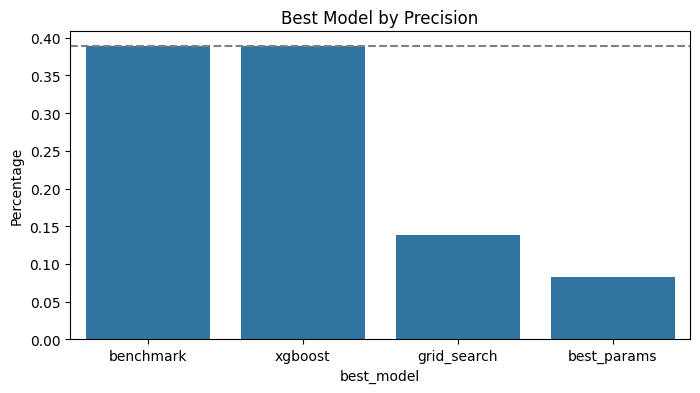

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

precision_plot = precision.best_model.value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=precision_plot.index, y=precision_plot.values, ax=ax)
ax.set_title('Best Model by Precision')
ax.set_ylabel('Percentage')
plt.axhline(0.388889, color='gray', linestyle='--', label='Benchmark')

plt.show()

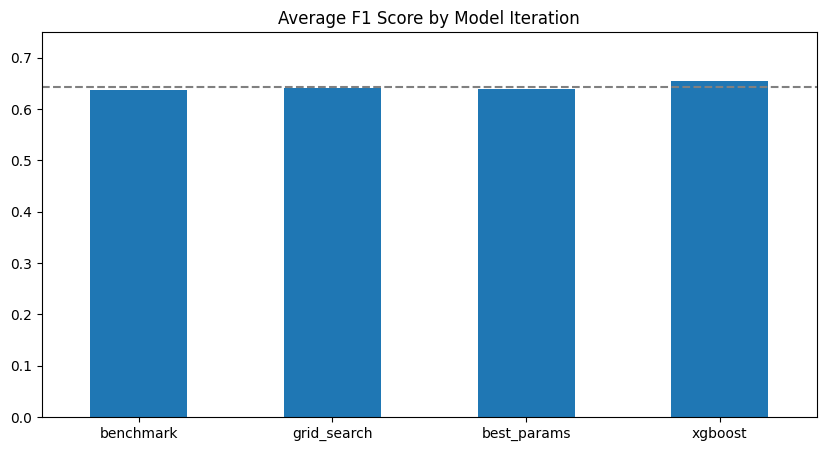

In [162]:
# create df for f1 scores
f1 = results_df(results,'f1')

# plot results
f1.iloc[:,2:6].mean().plot(kind='bar', figsize=(10,5), title='Average F1 Score by Model Iteration')
plt.xticks(rotation=0)
plt.ylim(0,.75)
plt.axhline(f1.iloc[:,2:6].mean().mean(), color='gray', linestyle='--')

### 11.  Final Comparison of all Models - 3rd iteration


### Consolidate Metrics

### Plot Models Performance

### Let's Extract The Data for Analysis

### Extract Feature Importance

In [90]:
# process the X_train data through the pipeline
X_train_processed = pipeline.named_steps['vect'].transform(X_train)
X_train_processed = pipeline.named_steps['tfidf'].transform(X_train_processed)

# extract the feature names
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

# extract the feature importances
feature_importances = pipeline.named_steps['clf'].estimators_[0].feature_importances_

# create a dataframe with the feature names and importances
df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# save df to csv
df.to_csv('../data/feature_importances.csv', index=False)

### Extract The Training and Test Data to see Distribution of Labels

In [91]:
# create df with X_train_processed
X_train_df = pd.DataFrame(X_train_processed.toarray(), columns=feature_names)

# merge with y_train
X_train_df = pd.concat([X_train_df, y_train.reset_index(drop=True)], axis=1)

X_train_df.shape

# save X_train_df to csv
X_train_df.to_csv('../data/X_train_df.csv', index=False)

In [92]:
# extract test features
X_test_processed = pipeline.named_steps['vect'].transform(X_test)
X_test_processed = pipeline.named_steps['tfidf'].transform(X_test_processed)

# create df with X_test_processed
X_test_df = pd.DataFrame(X_test_processed.toarray(), columns=feature_names)

# merge with y_test
X_test_df = pd.concat([X_test_df, y_test.reset_index(drop=True)], axis=1)

# save to csv
X_test_df.to_csv('../data/X_test_df.csv', index=False)



### Summary of Model Training Iterations
1.  Benchmark model: RandomForestClassifier - showed 95% accuracy
2.  Grid Search: We tried 4 different sets of hyperparameters with cross validation.  However, the model seriously underfit and could not detect most of the postive classes.
3.  XGBoost - We tried XGBoost with GridSearch and it showed 95% accuracy.  We saved this model as the final model.

### 12. Export your model as a pickle file

In [93]:
# export your model as a pickel file
import joblib
with open('xgb_classifier.pkl', 'wb') as file:
    joblib.dump(pipeline, file, compress=5)

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.